<a href="https://colab.research.google.com/github/dev-priyanshu15/OCR/blob/main/handwrittenlinelevelrecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#cell 1--Install Dependencies
print("Installing required packages for handwriting recognition...")
!pip install transformers torch torchvision torchaudio --quiet
!pip install datasets pillow opencv-python matplotlib pandas tqdm --quiet
!pip install psutil --quiet
print("All packages installed successfully!")
# Verify installations
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from tqdm import tqdm
import psutil
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
print("All imports successful!")
print("\nNext: Run Cell 2 to mount Google Drive (optional)")

Installing required packages for handwriting recognition...
All packages installed successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False
All imports successful!

Next: Run Cell 2 to mount Google Drive (optional)


In [2]:
# Cell 2--Mount Google Drive (Optional)
from google.colab import drive, files
import io

def mount_google_drive():
    """Mount Google Drive for file storage"""
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully at /content/drive")

        # Test drive access
        if os.path.exists('/content/drive/MyDrive'):
            print("Drive access verified")
            return True
        else:
            print("Drive access failed")
            return False
    except Exception as e:
        print(f"Drive mounting error: {e}")
        return False

# Mount drive
print("Mounting Google Drive...")
drive_mounted = mount_google_drive()

if drive_mounted:
    print("Google Drive setup complete")
    print("Results will be saved to: /content/drive/MyDrive/handwriting_results/")
else:
    print("Google Drive not mounted. Results will only be saved locally.")

print("\nNext: Run Cell 3 to download IAM dataset")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully at /content/drive
Drive access verified
Google Drive setup complete
Results will be saved to: /content/drive/MyDrive/handwriting_results/

Next: Run Cell 3 to download IAM dataset


In [3]:
# Cell 3: IAM Dataset Loader
# This cell downloads and processes the IAM handwriting dataset
class IAMDatasetLoader:
    """Loads and processes IAM handwriting dataset"""
    def __init__(self):
        self.dataset = None
        self.valid_samples = []
        self.vocabulary = set()
    def download_iam_dataset(self):
        """Download IAM dataset from HuggingFace"""
        print("Downloading IAM handwriting dataset...")
        print("This may take a few minutes for first time...")
        try:
            # Try to load IAM dataset
            self.dataset = load_dataset("alpayariyak/IAM_Sentences_LLaVA_json", split="train[:1000]")
            print("Dataset loaded successfully!")
            print(f"Total samples available: {len(self.dataset)}")
            return True
        except Exception as e:
            print(f"Failed to download dataset: {e}")
            print("Trying alternative approach...")
            try:
                # Create mock samples for testing
                self._create_sample_data()
                return True
            except Exception as e2:
                print(f"Alternative failed: {e2}")
                print("Proceeding without dataset context")
                return False
    def _create_sample_data(self):
        """Create sample data if dataset fails to load"""
        print("Creating sample vocabulary for handwriting recognition...")
        # Common handwriting words
        common_words = [
            "the", "and", "to", "of", "a", "in", "is", "it", "you", "that",
            "he", "was", "for", "on", "are", "as", "with", "his", "they", "i",
            "at", "be", "this", "have", "from", "or", "one", "had", "by", "word",
            "but", "not", "what", "all", "were", "we", "when", "your", "can", "said",
            "each", "she", "which", "their", "time", "will", "about", "if", "up", "out"
        ]
        self.vocabulary = set(common_words)
        print(f"Sample vocabulary created: {len(self.vocabulary)} words")
    def process_dataset_samples(self, sample_limit=500):
        """Extract valid text samples from dataset"""
        if not self.dataset:
            print("No dataset loaded, using sample vocabulary...")
            self._create_sample_data()
            return []
        print(f"Processing {sample_limit} samples from dataset...")
        valid_samples = []
        for idx, sample in enumerate(tqdm(self.dataset[:sample_limit])):
            try:
                text_content = self._extract_text_from_sample(sample)

                if text_content and self._is_valid_text(text_content):
                    valid_samples.append({
                        'sample_id': f'iam_sample_{idx}',
                        'text_content': text_content
                    })
                    # Add words to vocabulary
                    words = text_content.lower().split()
                    self.vocabulary.update(words)
            except Exception as e:
                continue
        self.valid_samples = valid_samples
        print(f"Successfully processed {len(valid_samples)} valid samples")
        print(f"Vocabulary size: {len(self.vocabulary)} words")
        if valid_samples:
            print("Sample text examples:")
            for i, sample in enumerate(valid_samples[:3]):
                print(f"  {i+1}. {sample['text_content'][:60]}...")
        return valid_samples
    def _extract_text_from_sample(self, sample):
        """Extract text content from sample"""
        if isinstance(sample, dict) and 'conversations' in sample:
            for conv in sample['conversations']:
                if 'value' in conv:
                    text = conv['value']
                    if len(text) > 10 and not any(word in text.lower() for word in ['transcribe', 'image', 'describe']):
                        return text
        return None
    def _is_valid_text(self, text):
        """Check if text is valid for training"""
        if not isinstance(text, str):
            return False
        cleaned = text.strip()
        return 5 < len(cleaned) < 200 and cleaned.replace(' ', '').isalnum()
    def get_vocabulary_set(self):
        """Get the vocabulary set"""
        return self.vocabulary
# Initialize and load dataset
print("Initializing IAM Dataset Loader...")
iam_loader = IAMDatasetLoader()
# Download and process dataset
if iam_loader.download_iam_dataset():
    samples = iam_loader.process_dataset_samples()
    print(f"Dataset setup complete. Processed {len(samples)} samples.")
else:
    print("Dataset setup completed with basic vocabulary.")
print("\nNext: Run Cell 4 to setup image enhancement")

Initializing IAM Dataset Loader...
This may take a few minutes for first time...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/506 [00:00<?, ?B/s]

data/train-00000-of-00001-6ee4e51ea53df1(…):   0%|          | 0.00/418k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5663 [00:00<?, ? examples/s]

Dataset loaded successfully!
Total samples available: 1000
Processing 500 samples from dataset...


100%|██████████| 3/3 [00:00<00:00, 14786.03it/s]

Successfully processed 0 valid samples
Vocabulary size: 0 words
Dataset setup complete. Processed 0 samples.

Next: Run Cell 4 to setup image enhancement


In [4]:
# Cell 4: Image Enhancement Engine
# This cell sets up image preprocessing for better handwriting recognition
class HandwritingImageEnhancer:
    """Specialized image enhancement for handwritten text"""
    def __init__(self):
        self.target_size = 2048
        self.enhancement_params = {
            'contrast_factor': 1.5,
            'sharpness_factor': 1.3,
            'threshold_block_size': 11,
            'threshold_constant': 2
        }
        print("Image enhancer initialized with optimal parameters")
    def enhance_image(self, input_image):
        """Complete image enhancement pipeline"""
        # Load and convert image
        pil_image = self._load_and_convert_image(input_image)
        original_copy = pil_image.copy()
        # Apply enhancement steps
        enhanced_image = self._apply_enhancement_pipeline(pil_image)
        return enhanced_image, original_copy
    def _load_and_convert_image(self, input_image):
        """Load image from various input formats"""
        if isinstance(input_image, bytes):
            image = Image.open(io.BytesIO(input_image))
        elif isinstance(input_image, str):
            image = Image.open(input_image)
        else:
            image = input_image
        # Ensure RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image
    def _apply_enhancement_pipeline(self, image):
        """Apply complete enhancement pipeline"""
        # Step 1: Intelligent resizing
        resized_image = self._smart_resize(image)
        # Step 2: Contrast enhancement
        contrast_enhanced = self._enhance_contrast(resized_image)
        # Step 3: Sharpness enhancement
        sharpness_enhanced = self._enhance_sharpness(contrast_enhanced)
        # Step 4: OpenCV processing for text clarity
        final_image = self._apply_opencv_enhancement(sharpness_enhanced)
        return final_image
    def _smart_resize(self, image):
        """Intelligently resize image if needed"""
        width, height = image.size
        max_dimension = max(width, height)
        if max_dimension > self.target_size:
            scale_factor = self.target_size / max_dimension
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)

            resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
            print(f"Image resized from {image.size} to {resized.size}")
            return resized
        return image
    def _enhance_contrast(self, image):
        """Enhance image contrast for better text visibility"""
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(self.enhancement_params['contrast_factor'])
    def _enhance_sharpness(self, image):
        """Enhance image sharpness for clearer text edges"""
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(self.enhancement_params['sharpness_factor'])
    def _apply_opencv_enhancement(self, image):
        """Apply OpenCV operations for text recognition optimization"""
        # Convert PIL to OpenCV format
        opencv_image = np.array(image)
        grayscale = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2GRAY)
        # Adaptive thresholding for handwriting
        binary_image = cv2.adaptiveThreshold(
            grayscale,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            self.enhancement_params['threshold_block_size'],
            self.enhancement_params['threshold_constant']
        )
        # Morphological operations for noise reduction
        morphology_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, morphology_kernel)
        # Convert back to PIL RGB
        final_image = Image.fromarray(cleaned_image).convert('RGB')
        return final_image
# Test image enhancer
print("Setting up Image Enhancement Engine...")
image_enhancer = HandwritingImageEnhancer()
print("Image enhancer ready for processing")
print("\nNext: Run Cell 5 to setup TrOCR recognition engine")

Setting up Image Enhancement Engine...
Image enhancer initialized with optimal parameters
Image enhancer ready for processing

Next: Run Cell 5 to setup TrOCR recognition engine


In [5]:
# Cell 5: TrOCR Recognition Engine
# This cell loads the TrOCR model for handwriting recognition
class TrOCRHandwritingEngine:
    """TrOCR engine optimized for handwriting recognition"""
    def __init__(self):
        self.processor = None
        self.model = None
        self.device = None
        self.iam_vocabulary = set()
        self._load_trocr_model()
    def _load_trocr_model(self):
        """Load TrOCR model and processor"""
        print("Loading TrOCR handwritten text model...")
        print("This will download the model (may take a few minutes first time)")
        model_name = "microsoft/trocr-base-handwritten"
        try:
            self.processor = TrOCRProcessor.from_pretrained(model_name)
            self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
            # Setup device
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model.to(self.device)
            print(f"TrOCR model loaded successfully on {self.device}")
            print(f"Model: {model_name}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    def load_iam_vocabulary(self, iam_loader):
        """Load vocabulary from IAM dataset"""
        print("Loading IAM vocabulary for context...")
        try:
            self.iam_vocabulary = iam_loader.get_vocabulary_set()
            print(f"IAM vocabulary loaded: {len(self.iam_vocabulary)} unique words")
        except Exception as e:
            print(f"Vocabulary loading error: {e}")
            print("Proceeding without vocabulary context")
    def recognize_handwriting(self, enhanced_image):
        """Perform handwriting recognition on enhanced image"""
        try:
            # Prepare image for TrOCR
            pixel_values = self.processor(
                images=enhanced_image,
                return_tensors="pt"
            ).pixel_values
            # Move to appropriate device
            pixel_values = pixel_values.to(self.device)
            # Generate text with optimized parameters
            with torch.no_grad():
                generated_token_ids = self.model.generate(
                    pixel_values,
                    max_length=256,
                    num_beams=5,
                    early_stopping=True,
                    do_sample=False,
                    pad_token_id=self.processor.tokenizer.pad_token_id
                )
            # Decode tokens to text
            recognized_text = self.processor.batch_decode(
                generated_token_ids,
                skip_special_tokens=True
            )[0]
            return recognized_text
        except Exception as e:
            print(f"Recognition error: {e}")
            return ""
# Initialize TrOCR engine
print("Initializing TrOCR Recognition Engine...")
trocr_engine = TrOCRHandwritingEngine()
# Load vocabulary from IAM loader
if 'iam_loader' in globals():
    trocr_engine.load_iam_vocabulary(iam_loader)
print("TrOCR engine ready for recognition")
print("\nNext: Run Cell 6 to setup text analysis and confidence scoring")

Initializing TrOCR Recognition Engine...
Loading TrOCR handwritten text model...
This will download the model (may take a few minutes first time)


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TrOCR model loaded successfully on cpu
Model: microsoft/trocr-base-handwritten
Loading IAM vocabulary for context...
IAM vocabulary loaded: 0 unique words
TrOCR engine ready for recognition

Next: Run Cell 6 to setup text analysis and confidence scoring


In [6]:
# Cell 6: Text Analysis and Confidence Scoring
# This cell sets up text processing and confidence calculation
class TextAnalyzer:
    """Analyzes and post-processes recognized text"""
    def __init__(self, vocabulary=None):
        self.vocabulary = vocabulary or set()
        print(f"Text analyzer initialized with vocabulary size: {len(self.vocabulary)}")
    def process_recognized_text(self, raw_text):
        """Clean and process raw recognition output"""
        if not raw_text:
            return ""
        # Remove non-printable characters
        cleaned = ''.join(char for char in raw_text if char.isprintable())
        # Normalize whitespace
        normalized = ' '.join(cleaned.split())
        return normalized.strip()
    def calculate_text_confidence(self, processed_text):
        """Calculate confidence score for recognized text"""
        if not processed_text or len(processed_text.strip()) == 0:
            return 0.0
        confidence_scores = []
        # Length appropriateness score
        length_score = self._get_length_score(processed_text)
        confidence_scores.append(length_score)
        # Vocabulary matching score
        if self.vocabulary:
            vocab_score = self._get_vocabulary_score(processed_text)
            confidence_scores.append(vocab_score)
        # Character distribution score
        char_score = self._get_character_score(processed_text)
        confidence_scores.append(char_score)
        # Return weighted average
        return sum(confidence_scores) / len(confidence_scores)
    def _get_length_score(self, text):
        """Score based on text length appropriateness"""
        text_length = len(text)
        if text_length <= 30:
            return min(1.0, text_length / 30.0)
        else:
            penalty = (text_length - 30) / 50.0
            return max(0.7, 1.0 - penalty)
    def _get_vocabulary_score(self, text):
        """Score based on vocabulary matching"""
        words = text.lower().split()
        if not words:
            return 0.0
        recognized_words = 0
        for word in words:
            if word in self.vocabulary or len(word) <= 2:
                recognized_words += 1
        return min(1.0, recognized_words / len(words))
    def _get_character_score(self, text):
        """Score based on character distribution"""
        if len(text) == 0:
            return 0.0
        alphabetic_chars = sum(1 for char in text if char.isalpha())
        alpha_ratio = alphabetic_chars / len(text)
        # Account for spaces and punctuation
        return min(1.0, alpha_ratio + 0.3)
# Initialize text analyzer with IAM vocabulary
print("Setting up Text Analysis and Confidence Scoring...")
if 'iam_loader' in globals():
    vocabulary = iam_loader.get_vocabulary_set()
else:
    vocabulary = set()
text_analyzer = TextAnalyzer(vocabulary)
print("Text analyzer ready for processing")
print("\nNext: Run Cell 7 to create the complete recognition system")

Setting up Text Analysis and Confidence Scoring...
Text analyzer initialized with vocabulary size: 0
Text analyzer ready for processing

Next: Run Cell 7 to create the complete recognition system


In [7]:
# Cell 7: Complete Recognition System
# This cell combines all components into a unified system
class ColabHandwritingRecognizer:
    """Complete handwriting recognition system for Colab"""
    def __init__(self):
        print("Initializing Complete Handwriting Recognition System...")
        # Use global components
        self.image_enhancer = image_enhancer
        self.trocr_engine = trocr_engine
        self.text_analyzer = text_analyzer
        print("All components integrated successfully")
    def recognize_image(self, image_data):
        """Recognize text from single image"""
        try:
            print("Processing image...")
            # Enhance image for recognition
            enhanced_image, original_image = self.image_enhancer.enhance_image(image_data)
            print("Image enhancement completed")
            # Perform text recognition
            raw_text = self.trocr_engine.recognize_handwriting(enhanced_image)
            print(f"Raw recognition: '{raw_text}'")
            # Process and analyze text
            final_text = self.text_analyzer.process_recognized_text(raw_text)
            confidence_score = self.text_analyzer.calculate_text_confidence(final_text)
            print(f"Final text: '{final_text}'")
            print(f"Confidence: {confidence_score:.1%}")
            # Compile results
            recognition_result = {
                'recognized_text': final_text,
                'raw_recognition': raw_text,
                'confidence_score': confidence_score,
                'enhanced_image': enhanced_image,
                'original_image': original_image,
                'recognition_method': 'TrOCR + IAM Context'
            }
            return recognition_result
        except Exception as e:
            print(f"Recognition error: {e}")
            return {
                'recognized_text': '',
                'raw_recognition': '',
                'confidence_score': 0.0,
                'enhanced_image': None,
                'original_image': None,
                'error_message': str(e),
                'recognition_method': 'TrOCR + IAM Context'
            }
    def process_multiple_images(self, image_collection):
        """Process multiple images in sequence"""
        all_results = []
        total_images = len(image_collection)
        print(f"Processing {total_images} uploaded images...")
        for filename, image_data in image_collection.items():
            print(f"\nProcessing: {filename}")
            # Recognize text
            result = self.recognize_image(image_data)
            # Create summary result
            summary_result = {
                'filename': filename,
                'recognized_text': result['recognized_text'],
                'confidence_score': result['confidence_score'],
                'recognition_method': result['recognition_method']
            }
            all_results.append(summary_result)
            # Show progress
            text_preview = result['recognized_text'][:40]
            if len(result['recognized_text']) > 40:
                text_preview += "..."
            print(f"Result: '{text_preview}'")
            print(f"Confidence: {result['confidence_score']:.1%}")
        return all_results
# Initialize complete recognition system
print("Creating Complete Recognition System...")
recognizer = ColabHandwritingRecognizer()
print("System ready for handwriting recognition!")
print("\nNext: Run Cell 8 to setup visualization and results display")

Creating Complete Recognition System...
Initializing Complete Handwriting Recognition System...
All components integrated successfully
System ready for handwriting recognition!

Next: Run Cell 8 to setup visualization and results display


In [8]:
# Cell 8: Visualization and Results Display
# This cell sets up visualization for recognition results
class ColabVisualizer:
    """Visualization manager for Colab environment"""
    def __init__(self):
        self.plot_size = (15, 10)
    def display_single_result(self, filename, result):
        """Display result for single image"""
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=self.plot_size)
        # Display original image
        if result['original_image']:
            axes[0, 0].imshow(result['original_image'])
            axes[0, 0].set_title(f'Original: {filename}', fontsize=12)
            axes[0, 0].axis('off')
        # Display enhanced image
        if result['enhanced_image']:
            axes[0, 1].imshow(result['enhanced_image'])
            axes[0, 1].set_title('Enhanced for Recognition', fontsize=12)
            axes[0, 1].axis('off')
        # Display recognition results
        self._add_text_results_panel(axes[1, 0], result)
        # Display system information
        self._add_system_info_panel(axes[1, 1], result)
        # Finalize plot
        plt.tight_layout()
        plt.show()
        # Print detailed summary
        self._print_detailed_summary(filename, result)
    def display_batch_results(self, batch_results):
        """Display summary of batch results"""
        if not batch_results:
            print("No results to display")
            return
        print("=" * 60)
        print("BATCH RECOGNITION RESULTS SUMMARY")
        print("=" * 60)
        for i, result in enumerate(batch_results, 1):
            confidence_bar = "█" * int(result['confidence_score'] * 10)
            confidence_bar += "░" * (10 - int(result['confidence_score'] * 10))
            print(f"\n{i}. {result['filename']}")
            print(f"   Text: {result['recognized_text']}")
            print(f"   Confidence: [{confidence_bar}] {result['confidence_score']:.1%}")
        # Calculate statistics
        confidences = [r['confidence_score'] for r in batch_results]
        avg_confidence = sum(confidences) / len(confidences)
        print("\n" + "=" * 60)
        print("BATCH STATISTICS")
        print("=" * 60)
        print(f"Total files processed: {len(batch_results)}")
        print(f"Average confidence: {avg_confidence:.1%}")
        print(f"Highest confidence: {max(confidences):.1%}")
        print(f"Lowest confidence: {min(confidences):.1%}")
    def _add_text_results_panel(self, ax, result):
        """Add text recognition results to subplot"""
        ax.text(0.05, 0.85, "RECOGNITION RESULTS:", fontsize=14, weight='bold')
        # Wrap long text
        text = result['recognized_text']
        if len(text) > 50:
            text = text[:50] + "..."
        ax.text(0.05, 0.65, f"Text: '{text}'", fontsize=11)
        ax.text(0.05, 0.45, f"Confidence: {result['confidence_score']:.1%}", fontsize=11)
        ax.text(0.05, 0.25, f"Method: {result['recognition_method']}", fontsize=10)
        if 'error_message' in result:
            ax.text(0.05, 0.05, f"Error: {result['error_message']}", fontsize=9, color='red')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
    def _add_system_info_panel(self, ax, result):
        """Add system information to subplot"""
        ax.text(0.05, 0.85, "SYSTEM INFORMATION:", fontsize=14, weight='bold')
        ax.text(0.05, 0.65, f"Text Length: {len(result['recognized_text'])} chars", fontsize=11)
        raw_preview = result.get('raw_recognition', '')[:25]
        if len(result.get('raw_recognition', '')) > 25:
            raw_preview += "..."
        ax.text(0.05, 0.45, f"Raw Output: '{raw_preview}'", fontsize=9)
        ax.text(0.05, 0.25, "Status: Processing Complete", fontsize=10, color='green')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
    def _print_detailed_summary(self, filename, result):
        """Print detailed console summary"""
        print("=" * 70)
        print(f"FILE: {filename}")
        print(f"RECOGNIZED TEXT: {result['recognized_text']}")
        print(f"CONFIDENCE: {result['confidence_score']:.1%}")
        print(f"METHOD: {result['recognition_method']}")

        if 'error_message' in result:
            print(f"ERROR: {result['error_message']}")

        print("=" * 70)
# Initialize visualizer
print("Setting up Visualization System...")
visualizer = ColabVisualizer()
print("Visualization system ready")
print("\nNext: Run Cell 9 to setup file upload and processing")

Setting up Visualization System...
Visualization system ready

Next: Run Cell 9 to setup file upload and processing


In [9]:
# Cell 9: File Upload and Processing Interface
# This cell provides the main interface for uploading and processing images
def upload_and_process_images():
    """Main function to upload and process handwriting images"""
    print("=" * 60)
    print("HANDWRITING RECOGNITION - FILE UPLOAD")
    print("=" * 60)
    print("Please upload your handwritten text images")
    print("Supported formats: JPG, PNG, JPEG")
    print("Click 'Choose Files' button below to select images")
    print("=" * 60)
    # Upload files
    uploaded_files = files.upload()
    if not uploaded_files:
        print("No files were uploaded")
        return
    print(f"\n{len(uploaded_files)} files uploaded successfully")
    # Show processing options
    print("\nProcessing Options:")
    print("1. Quick Recognition (text only)")
    print("2. Detailed Analysis (with images)")
    print("3. Batch Processing (with export)")
    choice = input("\nEnter your choice (1, 2, or 3): ").strip()
    if choice == "1":
        quick_recognition(uploaded_files)
    elif choice == "2":
        detailed_analysis(uploaded_files)
    elif choice == "3":
        batch_processing(uploaded_files)
    else:
        print("Invalid choice. Using detailed analysis...")
        detailed_analysis(uploaded_files)
def quick_recognition(uploaded_files):
    """Quick text recognition only"""
    print("\nQUICK RECOGNITION MODE")
    print("-" * 30)
    for filename, image_data in uploaded_files.items():
        print(f"\nProcessing: {filename}")
        result = recognizer.recognize_image(image_data)
        confidence_display = f"({result['confidence_score']:.0%})"
        print(f"Text: '{result['recognized_text']}' {confidence_display}")
def detailed_analysis(uploaded_files):
    """Detailed analysis with visualization"""
    print("\nDETAILED ANALYSIS MODE")
    print("-" * 30)
    for filename, image_data in uploaded_files.items():
        result = recognizer.recognize_image(image_data)
        visualizer.display_single_result(filename, result)
def batch_processing(uploaded_files):
    """Batch processing with export"""
    print("\nBATCH PROCESSING MODE")
    print("-" * 30)
    # Process all images
    batch_results = recognizer.process_multiple_images(uploaded_files)
    # Display summary
    visualizer.display_batch_results(batch_results)
    # Export to CSV
    export_results_to_csv(batch_results)
def export_results_to_csv(results):
    """Export results to CSV file"""
    if not results:
        print("No results to export")
        return
    df = pd.DataFrame(results)
    # Save locally
    local_path = '/content/handwriting_results.csv'
    df.to_csv(local_path, index=False)
    print(f"\nResults saved locally: {local_path}")
    # Save to Drive if mounted
    if 'drive_mounted' in globals() and drive_mounted:
        try:
            drive_path = '/content/drive/MyDrive/handwriting_results.csv'
            df.to_csv(drive_path, index=False)
            print(f"Results saved to Google Drive: {drive_path}")
        except Exception as e:
            print(f"Drive save failed: {e}")
    # Download file
    try:
        files.download(local_path)
        print("Download initiated for CSV file")
    except Exception as e:
        print(f"Download error: {e}")
# System status check
def check_system_status():
    """Check if all components are ready"""
    components = {
        'Image Enhancer': 'image_enhancer' in globals(),
        'TrOCR Engine': 'trocr_engine' in globals(),
        'Text Analyzer': 'text_analyzer' in globals(),
        'Recognizer': 'recognizer' in globals(),
        'Visualizer': 'visualizer' in globals()
    }
    print("SYSTEM STATUS CHECK")
    print("-" * 20)
    for component, status in components.items():
        status_text = "READY" if status else "NOT READY"
        print(f"{component}: {status_text}")
    all_ready = all(components.values())
    if all_ready:
        print("\nAll components are ready!")
        return True
    else:
        print("\nSome components are not ready. Please run previous cells.")
        return False
# Check system and show instructions
if check_system_status():
    print("\n" + "=" * 60)
    print("SYSTEM READY FOR HANDWRITING RECOGNITION")
    print("=" * 60)
    print("Run: upload_and_process_images()")
    print("This will start the file upload interface")
else:
    print("\nPlease run all previous cells first")
print("\nNext: Run Cell 10 for quick start interface")

SYSTEM STATUS CHECK
--------------------
Image Enhancer: READY
TrOCR Engine: READY
Text Analyzer: READY
Recognizer: READY
Visualizer: READY

All components are ready!

SYSTEM READY FOR HANDWRITING RECOGNITION
Run: upload_and_process_images()
This will start the file upload interface

Next: Run Cell 10 for quick start interface


HANDWRITING RECOGNITION SYSTEM
Available Commands:
1. start_handwriting_recognition() - Start the main process
2. test_with_sample() - Test with sample data
3. show_system_info() - Show system information
4. check_system_status() - Check component status
5. quick_single_image_test() - Test with single image
6. run_system_diagnostics() - Full system test
Start handwriting recognition now? (y/n): y
STARTING HANDWRITING RECOGNITION SYSTEM
SYSTEM STATUS CHECK
--------------------
Image Enhancer: READY
TrOCR Engine: READY
Text Analyzer: READY
Recognizer: READY
Visualizer: READY

All components are ready!
System is ready! Starting file upload process...

Instructions:
1. Click 'Choose Files' when prompted
2. Select your handwritten text images
3. Choose processing mode
4. View results
HANDWRITING RECOGNITION - FILE UPLOAD
Please upload your handwritten text images
Supported formats: JPG, PNG, JPEG
Click 'Choose Files' button below to select images


Saving r06-076-s00-01.png to r06-076-s00-01.png

1 files uploaded successfully

Processing Options:
1. Quick Recognition (text only)
2. Detailed Analysis (with images)
3. Batch Processing (with export)

Enter your choice (1, 2, or 3): 2

DETAILED ANALYSIS MODE
------------------------------
Processing image...
Image enhancement completed
Raw recognition: 'Mediterranean people to whom nothing'
Final text: 'Mediterranean people to whom nothing'
Confidence: 94.0%


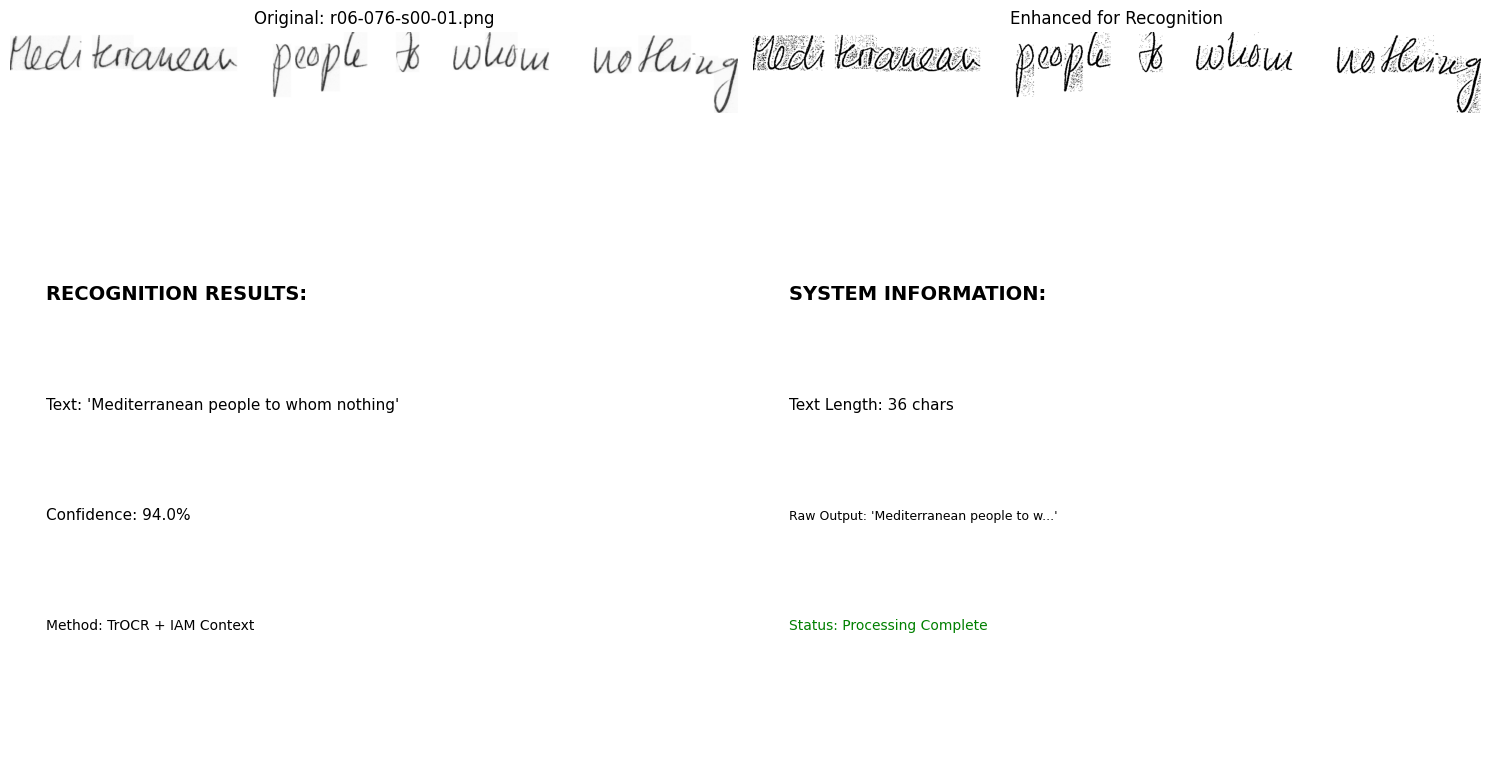

FILE: r06-076-s00-01.png
RECOGNIZED TEXT: Mediterranean people to whom nothing
CONFIDENCE: 94.0%
METHOD: TrOCR + IAM Context

Next: Run Cell 11 for advanced features and export options


In [10]:
# Cell 10: Quick Start Interface
# Run this cell to start the handwriting recognition process
def start_handwriting_recognition():
    """One-click start for handwriting recognition"""
    print("STARTING HANDWRITING RECOGNITION SYSTEM")
    print("=" * 50)
    # Check all components
    if not check_system_status():
        print("ERROR: System not ready. Please run all previous cells first.")
        return
    print("System is ready! Starting file upload process...")
    print("\nInstructions:")
    print("1. Click 'Choose Files' when prompted")
    print("2. Select your handwritten text images")
    print("3. Choose processing mode")
    print("4. View results")
    # Start upload process
    upload_and_process_images()
def test_with_sample():
    """Test system with a sample if no files are available"""
    print("TESTING SYSTEM WITH SAMPLE DATA")
    print("-" * 40)
    # Create a simple test image with text
    from PIL import Image, ImageDraw, ImageFont
    # Create white background
    img = Image.new('RGB', (400, 100), color='white')
    draw = ImageDraw.Draw(img)
    # Add some sample text (simulating handwriting)
    try:
        # Try to use default font
        font = ImageFont.load_default()
        draw.text((20, 30), "Hello World", fill='black', font=font)
    except:
        # Fallback without font
        draw.text((20, 30), "Hello World", fill='black')
    # Test recognition
    print("Testing recognition on sample image...")
    result = recognizer.recognize_image(img)
    print(f"Sample Recognition Result:")
    print(f"Text: '{result['recognized_text']}'")
    print(f"Confidence: {result['confidence_score']:.1%}")
    return result
def show_system_info():
    """Display comprehensive system information"""
    print("SYSTEM INFORMATION")
    print("=" * 30)
    # Memory info
    import psutil
    memory = psutil.virtual_memory()
    print(f"Available RAM: {memory.available // 1024**3} GB")
    # GPU info
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
    else:
        print("GPU: Not available (using CPU)")
    # Model info
    print(f"Model: microsoft/trocr-base-handwritten")
    # Dataset info
    if 'iam_loader' in globals() and hasattr(iam_loader, 'vocabulary'):
        print(f"Vocabulary Size: {len(iam_loader.vocabulary)} words")
    print("=" * 30)
def quick_single_image_test():
    """Quick test with single image upload"""
    print("QUICK SINGLE IMAGE TEST")
    print("-" * 25)
    print("Upload a single handwritten image for quick testing")
    uploaded = files.upload()
    if uploaded:
        filename = list(uploaded.keys())[0]
        image_data = list(uploaded.values())[0]
        print(f"Processing: {filename}")
        result = recognizer.recognize_image(image_data)
        print(f"Recognized Text: '{result['recognized_text']}'")
        print(f"Confidence: {result['confidence_score']:.1%}")
        return result
    else:
        print("No file uploaded")
        return None
def run_system_diagnostics():
    """Run complete system diagnostics"""
    print("RUNNING SYSTEM DIAGNOSTICS")
    print("=" * 35)
    # Check components
    print("1. Checking Components...")
    check_system_status()
    # Check memory
    print("\n2. Memory Check...")
    show_system_info()
    # Test sample recognition
    print("\n3. Testing Recognition...")
    test_with_sample()
    print("\nDiagnostics Complete!")
# Main interface
print("HANDWRITING RECOGNITION SYSTEM")
print("=" * 40)
print("Available Commands:")
print("1. start_handwriting_recognition() - Start the main process")
print("2. test_with_sample() - Test with sample data")
print("3. show_system_info() - Show system information")
print("4. check_system_status() - Check component status")
print("5. quick_single_image_test() - Test with single image")
print("6. run_system_diagnostics() - Full system test")
print("=" * 40)
# Auto-start option
try:
    auto_start = input("Start handwriting recognition now? (y/n): ").lower().strip()
    if auto_start == 'y':
        start_handwriting_recognition()
    else:
        print("\nRun start_handwriting_recognition() when ready")
except:
    print("Run start_handwriting_recognition() to begin")
print("\nNext: Run Cell 11 for advanced features and export options")

In [11]:
# Cell 11: Advanced Features and Export Options
# This cell provides advanced recognition features and export capabilities
class AdvancedRecognitionFeatures:
    """Additional advanced features for recognition"""
    def __init__(self, base_recognizer):
        self.base_recognizer = base_recognizer
        print("Advanced recognition features initialized")
    def recognize_with_multiple_preprocessing(self, image_data):
        """Try multiple preprocessing approaches and select best result"""
        preprocessing_variants = [
            {'name': 'Standard', 'params': {}},
            {'name': 'High Contrast', 'params': {'contrast_factor': 2.0}},
            {'name': 'Extra Sharp', 'params': {'sharpness_factor': 2.0}},
            {'name': 'Aggressive Threshold', 'params': {'threshold_block_size': 7}}
        ]
        best_result = None
        best_confidence = 0.0
        print("Testing multiple preprocessing variants...")
        for variant in preprocessing_variants:
            try:
                # Temporarily modify enhancer params
                original_params = self.base_recognizer.image_enhancer.enhancement_params.copy()
                self.base_recognizer.image_enhancer.enhancement_params.update(variant['params'])
                # Recognize with variant
                result = self.base_recognizer.recognize_image(image_data)
                print(f"{variant['name']}: Confidence {result['confidence_score']:.1%}")
                # Track best result
                if result['confidence_score'] > best_confidence:
                    best_confidence = result['confidence_score']
                    best_result = result
                    best_result['preprocessing_variant'] = variant['name']
                # Restore original params
                self.base_recognizer.image_enhancer.enhancement_params = original_params
            except Exception as e:
                print(f"Variant {variant['name']} failed: {e}")
                continue
        return best_result if best_result else self.base_recognizer.recognize_image(image_data)
class ResultsExporter:
    """Export and save recognition results"""
    def __init__(self):
        self.local_path = '/content/handwriting_results.csv'
        self.json_path = '/content/handwriting_results.json'
    def export_to_csv(self, results):
        """Export results to CSV format"""
        if not results:
            print("No results to export")
            return
        df = pd.DataFrame(results)
        df.to_csv(self.local_path, index=False)
        print(f"Results exported to: {self.local_path}")
        # Save to Google Drive if mounted
        if 'drive_mounted' in globals() and drive_mounted:
            try:
                drive_path = '/content/drive/MyDrive/handwriting_results.csv'
                df.to_csv(drive_path, index=False)
                print(f"Results saved to Google Drive: {drive_path}")
            except Exception as e:
                print(f"Drive save failed: {e}")
        # Download file
        try:
            files.download(self.local_path)
        except Exception as e:
            print(f"Download failed: {e}")
        return df
    def export_to_json(self, results):
        """Export results to JSON format"""
        if not results:
            print("No results to export")
            return
        with open(self.json_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results exported to JSON: {self.json_path}")
        try:
            files.download(self.json_path)
        except Exception as e:
            print(f"JSON download failed: {e}")
    def create_detailed_report(self, results):
        """Create a detailed text report"""
        if not results:
            print("No results for report")
            return
        report_path = '/content/recognition_report.txt'
        with open(report_path, 'w') as f:
            f.write("HANDWRITING RECOGNITION REPORT\n")
            f.write("=" * 40 + "\n\n")
            # Summary statistics
            confidences = [r['confidence_score'] for r in results]
            avg_conf = sum(confidences) / len(confidences)
            f.write(f"Total Files Processed: {len(results)}\n")
            f.write(f"Average Confidence: {avg_conf:.1%}\n")
            f.write(f"Highest Confidence: {max(confidences):.1%}\n")
            f.write(f"Lowest Confidence: {min(confidences):.1%}\n\n")
            # Detailed results
            f.write("DETAILED RESULTS:\n")
            f.write("-" * 20 + "\n")
            for i, result in enumerate(results, 1):
                f.write(f"\n{i}. File: {result['filename']}\n")
                f.write(f"   Text: {result['recognized_text']}\n")
                f.write(f"   Confidence: {result['confidence_score']:.1%}\n")
        print(f"Detailed report created: {report_path}")
        try:
            files.download(report_path)
        except Exception as e:
            print(f"Report download failed: {e}")
def batch_process_with_advanced_features(uploaded_files):
    """Process multiple files with advanced features"""
    print("ADVANCED BATCH PROCESSING")
    print("-" * 30)
    # Initialize advanced features
    advanced_recognizer = AdvancedRecognitionFeatures(recognizer)
    exporter = ResultsExporter()
    all_results = []
    for filename, image_data in uploaded_files.items():
        print(f"\nProcessing: {filename}")
        # Use advanced recognition
        result = advanced_recognizer.recognize_with_multiple_preprocessing(image_data)
        # Create summary
        summary = {
            'filename': filename,
            'recognized_text': result['recognized_text'],
            'confidence_score': result['confidence_score'],
            'preprocessing_variant': result.get('preprocessing_variant', 'Standard')
        }
        all_results.append(summary)
        print(f"Best result: '{result['recognized_text'][:40]}...'")
        print(f"Confidence: {result['confidence_score']:.1%}")
        print(f"Best method: {result.get('preprocessing_variant', 'Standard')}")
    # Export results
    print(f"\nExporting {len(all_results)} results...")
    # Export to multiple formats
    exporter.export_to_csv(all_results)
    exporter.export_to_json(all_results)
    exporter.create_detailed_report(all_results)
    return all_results
def confidence_analysis(results):
    """Analyze confidence scores and provide insights"""
    if not results:
        print("No results to analyze")
        return
    confidences = [r['confidence_score'] for r in results]
    print("CONFIDENCE ANALYSIS")
    print("-" * 20)
    print(f"Total samples: {len(confidences)}")
    print(f"Average confidence: {sum(confidences)/len(confidences):.1%}")
    print(f"Median confidence: {sorted(confidences)[len(confidences)//2]:.1%}")
    print(f"Highest confidence: {max(confidences):.1%}")
    print(f"Lowest confidence: {min(confidences):.1%}")
    # Confidence distribution
    high_conf = sum(1 for c in confidences if c >= 0.8)
    med_conf = sum(1 for c in confidences if 0.5 <= c < 0.8)
    low_conf = sum(1 for c in confidences if c < 0.5)
    print(f"\nConfidence Distribution:")
    print(f"High (80%+): {high_conf} files")
    print(f"Medium (50-80%): {med_conf} files")
    print(f"Low (<50%): {low_conf} files")
print("Advanced features and export options loaded")
print("\nAvailable functions:")
print("- batch_process_with_advanced_features(uploaded_files)")
print("- confidence_analysis(results)")
print("\nNext: Run Cell 12 for system utilities and maintenance")

Advanced features and export options loaded

Available functions:
- batch_process_with_advanced_features(uploaded_files)
- confidence_analysis(results)

Next: Run Cell 12 for system utilities and maintenance


In [12]:
# Cell 12: System Utilities and Maintenance
# This cell provides system maintenance and utility functions
def clear_memory():
    """Clear memory and reset components"""
    print("CLEARING SYSTEM MEMORY")
    print("-" * 25)
    # Clear CUDA cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cache cleared")
    # Force garbage collection
    import gc
    gc.collect()
    print("Python garbage collection completed")
    print("Memory clearing completed")
def system_memory_check():
    """Check current system memory usage"""
    print("SYSTEM MEMORY CHECK")
    print("-" * 20)
    # RAM usage
    memory = psutil.virtual_memory()
    print(f"RAM Total: {memory.total // 1024**3} GB")
    print(f"RAM Available: {memory.available // 1024**3} GB")
    print(f"RAM Used: {(memory.total - memory.available) // 1024**3} GB")
    print(f"RAM Usage: {memory.percent:.1f}%")
    # GPU memory if available
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)
        print(f"\nGPU Total: {gpu_memory // 1024**3} GB")
        print(f"GPU Allocated: {gpu_allocated // 1024**3} GB")
        print(f"GPU Cached: {gpu_cached // 1024**3} GB")
        print(f"GPU Free: {(gpu_memory - gpu_cached) // 1024**3} GB")
def reset_all_components():
    """Reset all system components"""
    print("RESETTING ALL COMPONENTS")
    print("-" * 30)
    try:
        # Clear memory first
        clear_memory()
        # Reinitialize components
        global image_enhancer, trocr_engine, text_analyzer, recognizer, visualizer
        print("Reinitializing components...")
        # Recreate components
        image_enhancer = HandwritingImageEnhancer()
        text_analyzer = TextAnalyzer()
        recognizer = ColabHandwritingRecognizer()
        visualizer = ColabVisualizer()
        print("All components reset successfully")
    except Exception as e:
        print(f"Reset failed: {e}")
        print("You may need to run previous cells again")
def create_system_backup():
    """Create backup of current system state"""
    print("CREATING SYSTEM BACKUP")
    print("-" * 25)
    backup_info = {
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'components_status': {
            'image_enhancer': 'image_enhancer' in globals(),
            'trocr_engine': 'trocr_engine' in globals(),
            'text_analyzer': 'text_analyzer' in globals(),
            'recognizer': 'recognizer' in globals(),
            'visualizer': 'visualizer' in globals()
        },
        'system_info': {
            'cuda_available': torch.cuda.is_available(),
            'python_version': f"{psutil.sys.version_info.major}.{psutil.sys.version_info.minor}",
            'torch_version': torch.__version__
        }
    }
    backup_path = '/content/system_backup.json'
    with open(backup_path, 'w') as f:
        json.dump(backup_info, f, indent=2)
    print(f"System backup created: {backup_path}")
    try:
        files.download(backup_path)
        print("Backup download initiated")
    except Exception as e:
        print(f"Backup download failed: {e}")
def performance_benchmark():
    """Run performance benchmark on the system"""
    print("RUNNING PERFORMANCE BENCHMARK")
    print("-" * 35)
    # Test image processing speed
    print("Testing image processing speed...")
    # Import required modules
    from PIL import ImageDraw
    # Create test image
    test_img = Image.new('RGB', (800, 400), color='white')
    draw = ImageDraw.Draw(test_img)
    draw.text((50, 150), "This is a test image for benchmarking", fill='black')
    # Time the recognition process
    import time
    start_time = time.time()
    result = recognizer.recognize_image(test_img)
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Recognition completed in {processing_time:.2f} seconds")
    print(f"Result: '{result['recognized_text']}'")
    print(f"Confidence: {result['confidence_score']:.1%}")
    # Performance rating
    if processing_time < 2:
        rating = "Excellent"
    elif processing_time < 5:
        rating = "Good"
    elif processing_time < 10:
        rating = "Fair"
    else:
        rating = "Slow"
    print(f"Performance Rating: {rating}")
    return processing_time
def cleanup_temporary_files():
    """Clean up temporary files created during processing"""
    print("CLEANING TEMPORARY FILES")
    print("-" * 25)
    temp_patterns = [
        '/content/*.csv',
        '/content/*.json',
        '/content/*.txt',
        '/content/results/*'
    ]
    import glob
    cleaned_count = 0
    for pattern in temp_patterns:
        files_to_clean = glob.glob(pattern)
        for file_path in files_to_clean:
            try:
                os.remove(file_path)
                cleaned_count += 1
            except Exception as e:
                print(f"Could not remove {file_path}: {e}")
    print(f"Cleaned {cleaned_count} temporary files")
def system_health_check():
    """Complete system health check"""
    print("SYSTEM HEALTH CHECK")
    print("=" * 25)
    # Check components
    print("1. Component Status:")
    check_system_status()
    # Check memory
    print("\n2. Memory Status:")
    system_memory_check()
    # Run benchmark
    print("\n3. Performance Test:")
    benchmark_time = performance_benchmark()
    # Overall health score
    components_ready = all([
        'image_enhancer' in globals(),
        'trocr_engine' in globals(),
        'text_analyzer' in globals(),
        'recognizer' in globals(),
        'visualizer' in globals()
    ])
    memory = psutil.virtual_memory()
    memory_ok = memory.percent < 90
    performance_ok = benchmark_time < 10
    health_score = sum([components_ready, memory_ok, performance_ok])
    print(f"\n4. Overall Health Score: {health_score}/3")
    if health_score == 3:
        print("System Status: HEALTHY")
    elif health_score == 2:
        print("System Status: GOOD")
    else:
        print("System Status: NEEDS ATTENTION")
# Utility functions menu
print("SYSTEM UTILITIES LOADED")
print("=" * 25)
print("Available utilities:")
print("1. system_health_check() - Complete system check")
print("2. clear_memory() - Clear system memory")
print("3. reset_all_components() - Reset all components")
print("4. performance_benchmark() - Test system performance")
print("5. cleanup_temporary_files() - Clean temp files")
print("6. create_system_backup() - Create system backup")
print("=" * 25)
# Auto health check
print("Running quick health check...")
try:
    system_health_check()
except Exception as e:
    print(f"Health check failed: {e}")
    print("Some components may need to be reinitialized")
print("\nNext: System is ready for use!")

SYSTEM UTILITIES LOADED
Available utilities:
1. system_health_check() - Complete system check
2. clear_memory() - Clear system memory
3. reset_all_components() - Reset all components
4. performance_benchmark() - Test system performance
5. cleanup_temporary_files() - Clean temp files
6. create_system_backup() - Create system backup
Running quick health check...
SYSTEM HEALTH CHECK
1. Component Status:
SYSTEM STATUS CHECK
--------------------
Image Enhancer: READY
TrOCR Engine: READY
Text Analyzer: READY
Recognizer: READY
Visualizer: READY

All components are ready!

2. Memory Status:
SYSTEM MEMORY CHECK
--------------------
RAM Total: 12 GB
RAM Available: 9 GB
RAM Used: 3 GB
RAM Usage: 27.6%

3. Performance Test:
RUNNING PERFORMANCE BENCHMARK
-----------------------------------
Testing image processing speed...
Processing image...
Image enhancement completed
Raw recognition: '1942 43'
Final text: '1942 43'
Confidence: 26.7%
Recognition completed in 10.69 seconds
Result: '1942 43'
Confid